# Hedging with Black-Scholes

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hestonpy.models.blackScholes import BlackScholes

import pandas as pd
dates = pd.date_range(start="2025-01-01", end="2025-07-01", freq="D")

nbr_simulations = 1000
nbr_hedges = len(dates)-1

## Replication errors

Sanity check of the replication

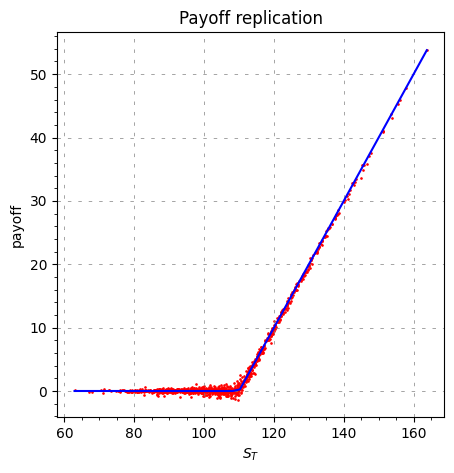

In [3]:
real_vol = 0.15
hedging_vol = 0.15

bs = BlackScholes(
    spot=100, r=0.01, mu=0.05, volatility=real_vol)
strike = 110

res = bs.delta_hedging(
    flag_option="call",
    time_to_maturity=1,
    strike=strike,
    hedging_volatility=hedging_vol,
    pricing_volatility=hedging_vol,
    nbr_simulations=nbr_simulations,
    nbr_hedges=nbr_hedges,
)

portfolio = res[0]
S = res[1]

ST = S[:, -1]
VT = portfolio[:, -1]

plt.figure(figsize=(5, 5))
plt.title("Payoff replication")
plt.grid(linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5)
plt.minorticks_on()
plt.xlabel(r"$S_T$")
plt.ylabel("payoff")
plt.scatter(ST, VT, s=0.8, color="red")
x = np.linspace(min(ST), max(ST))
payoff = np.maximum(0, x - strike)
plt.plot(x, payoff, color="blue")
plt.show()

Sanity check of the replicationCheck the replication errors

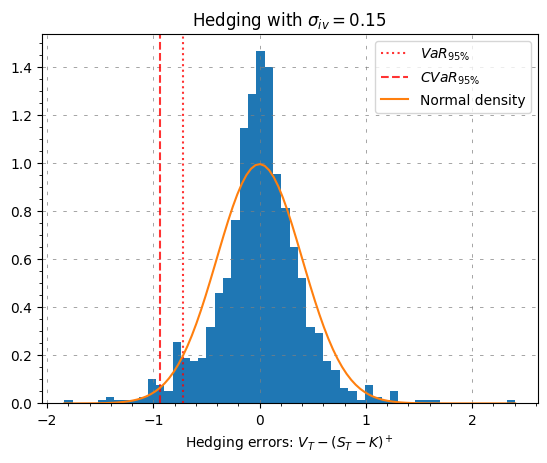

In [4]:
from scipy.stats import norm

cash_flows = np.maximum(0, ST - strike)
hedging_errors = VT - cash_flows

hedging_errors = np.sort(hedging_errors)
VaR95_index = int(0.05 * len(hedging_errors))
VaR95 = hedging_errors[VaR95_index]
CVaR95 = np.mean(hedging_errors[:VaR95_index])

plt.figure()

plt.title("Hedging with " + r"$\sigma_{iv} = $" + str(hedging_vol))
plt.hist(hedging_errors, bins="fd", density=True)

plt.axvline(VaR95, color='red', label=r'$VaR_{95\%}$', linestyle="dotted",alpha=0.8)
plt.axvline(CVaR95, color='red', label=r'$CVaR_{95\%}$', linestyle="--", alpha=0.8)

x = np.linspace(start=min(hedging_errors), stop=max(hedging_errors), num=100)
plt.plot(
    x,
    norm.pdf(x, loc=np.mean(hedging_errors), scale=np.std(hedging_errors)),
    label="Normal density",
)
plt.grid(linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5)
plt.minorticks_on()
plt.xlabel(r"Hedging errors: $V_T - (S_T - K)^+$")
plt.legend()
plt.show()

Looks like the hedging errors are fat tailed fat tailed

## Hedging with different volatilities

We analyse what is happening when we hedge with different volatilities (w.r.t to the pricing volatilities)

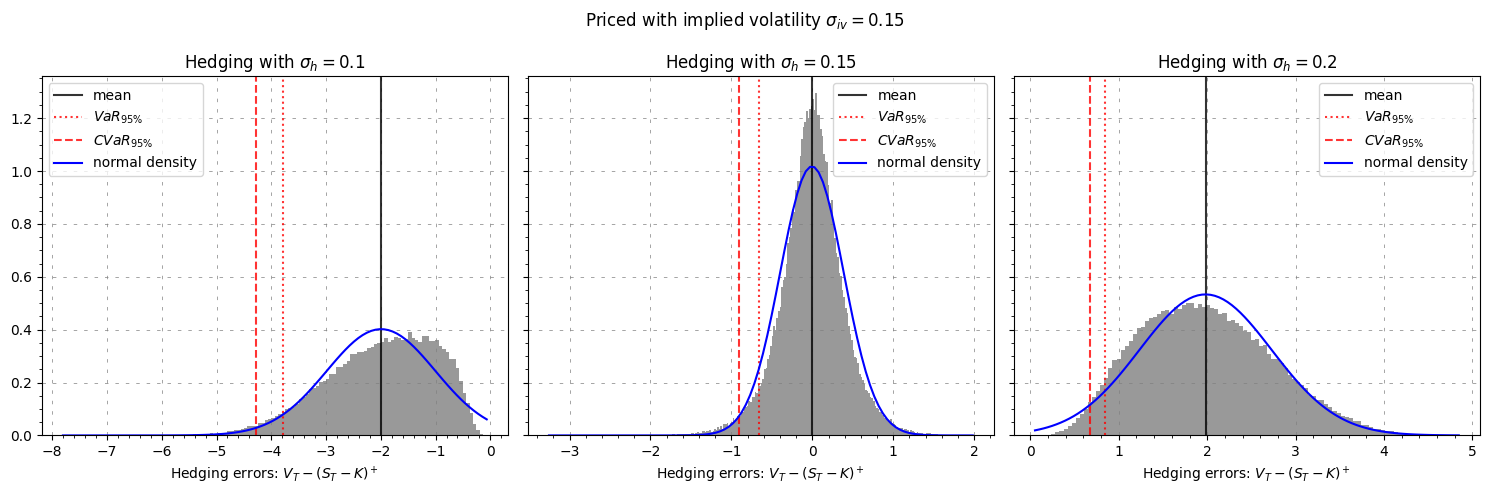

In [5]:
implied_volatility = 0.15
hedging_vols = [0.10, 0.15, 0.20]

bs = BlackScholes(spot=100, r=0.00, mu=0.00, volatility=implied_volatility)
strike = 100
nbr_simulations = 100000

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, vol in enumerate(hedging_vols):
    res = bs.delta_hedging(
        flag_option="call",
        time_to_maturity=1,
        strike=strike,
        hedging_volatility=vol,
        nbr_simulations=nbr_simulations,
        nbr_hedges=nbr_hedges,
    )

    portfolio = res[0]
    S = res[1]

    ST = S[:, -1]
    VT = portfolio[:, -1]

    cash_flows = np.maximum(0, ST - strike)
    hedging_errors = VT - cash_flows

    hedging_errors = np.sort(hedging_errors)
    VaR95_index = int(0.05 * len(hedging_errors))
    VaR95 = hedging_errors[VaR95_index]
    CVaR95 = np.mean(hedging_errors[:VaR95_index])

    axes[i].set_title("Hedging with " + r"$\sigma_{h} = $" + str(vol))
    axes[i].hist(hedging_errors, bins="fd", density=True, color="gray", alpha=0.8)
    axes[i].axvline(np.mean(hedging_errors), color="black", label="mean", alpha=0.8)
    axes[i].axvline(VaR95, color='red', label=r'$VaR_{95\%}$', linestyle="dotted",alpha=0.8)
    axes[i].axvline(CVaR95, color='red', label=r'$CVaR_{95\%}$', linestyle="--", alpha=0.8)

    x = np.linspace(start=min(hedging_errors), stop=max(hedging_errors), num=100)
    axes[i].plot(
        x,
        norm.pdf(x, loc=np.mean(hedging_errors), scale=np.std(hedging_errors)),
        label="normal density",
        color="blue",
    )
    axes[i].grid(linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5)
    axes[i].minorticks_on()
    axes[i].set_xlabel(r"Hedging errors: $V_T - (S_T - K)^+$")
    axes[i].legend()

plt.suptitle(
    r"Priced with implied volatility $\sigma_{iv} =$" + str(implied_volatility)
)
plt.tight_layout()
plt.show()

## Hedging at different frequencies

We analyse what is happening when we hedge daily, monthly or yearly

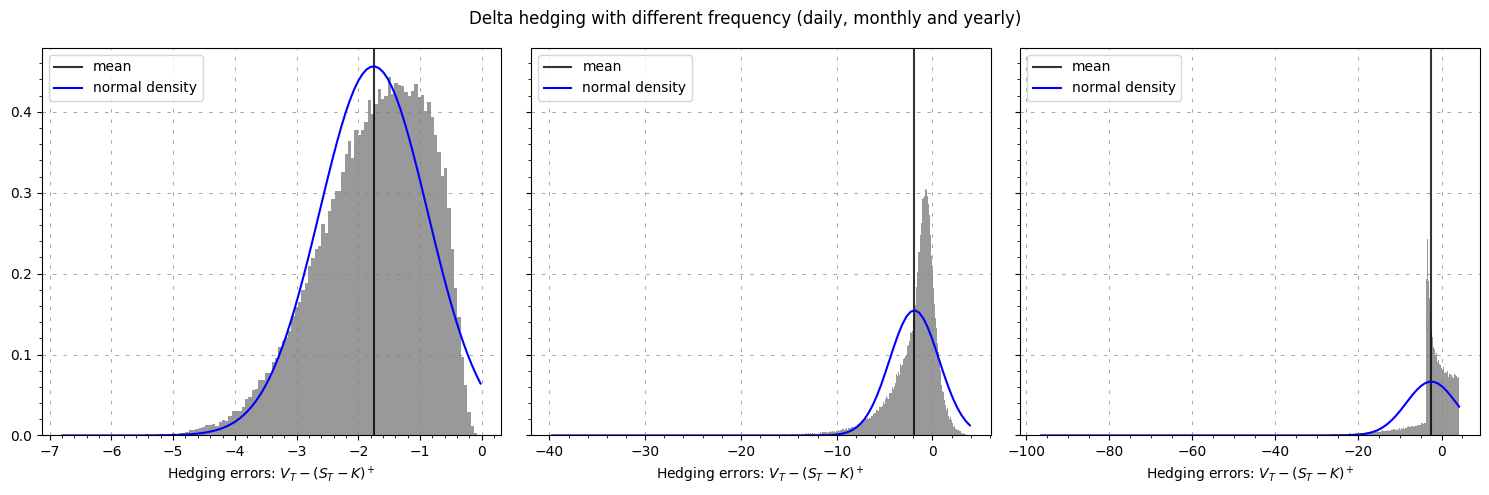

In [6]:
implied_volatility = 0.15
bs = BlackScholes(spot=100, r=0.00, mu=0.00, volatility=implied_volatility)
strike = 100

daily_dates = pd.date_range(start="2025-01-01", end="2025-07-01", freq="D")
monthly_dates = pd.date_range(start="2025-01-01", end="2025-07-01", freq="ME")
yearly_dates = [daily_dates[0]]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, dates in enumerate([daily_dates, monthly_dates, yearly_dates]):
    res = bs.delta_hedging(
        flag_option="call",
        time_to_maturity=0.5,
        strike=strike,
        hedging_volatility=implied_volatility,
        nbr_simulations=nbr_simulations,
        nbr_hedges=len(dates),
    )

    portfolio = res[0]
    S = res[1]

    ST = S[:, -1]
    VT = portfolio[:, -1]

    cash_flows = np.maximum(0, ST - strike)
    hedging_errors = VT - cash_flows

    hedging_errors = np.sort(hedging_errors)

    axes[i].hist(hedging_errors, bins="fd", density=True, color="gray", alpha=0.8)
    axes[i].axvline(np.mean(hedging_errors), color="black", label="mean", alpha=0.8)

    x = np.linspace(start=min(hedging_errors), stop=max(hedging_errors), num=100)
    axes[i].plot(
        x,
        norm.pdf(x, loc=np.mean(hedging_errors), scale=np.std(hedging_errors)),
        label="normal density",
        color="blue",
    )
    axes[i].grid(linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5)
    axes[i].minorticks_on()
    axes[i].set_xlabel(r"Hedging errors: $V_T - (S_T - K)^+$")
    axes[i].legend()

plt.suptitle("Delta hedging with different frequency (daily, monthly and yearly)")
plt.tight_layout()
plt.show()

## Hedging with a misspecified model

Since the market does not have perfect knowledge about the future actual and implied volatilities can and will be different.

Imagine that we have a forecast for volatility over the remaining life of an option, this volatility is forecast to be constant, and further assume that our forecast turns out to be correct. We shall buy an underpriced option and delta hedge to expiry.But which delta do you choose? Delta based on actual or implied volatility?

- **Scenario**: Implied volatility for an option is 20%, but we believe that actual volatility is 30%. 
- **Question**: How can we make money if our forecast is correct? 
- **Answer**: Buy the option and delta hedge. 
But which delta do we use?

In [7]:
np.random.seed(42)

# Model parameters
S0 = 100
mu = 0.00
r = 0.00
time_to_maturity = 1
stirke = 100

real_volatility = 0.30
implied_volatility = 0.20
model = BlackScholes(spot=100, r=r, mu=mu, volatility=real_volatility)

portfolio_iv, _ = model.volatility_arbitrage(
    pricing_volatility=implied_volatility,
    hedging_volatility=implied_volatility,
    strike=strike,
    time_to_maturity=time_to_maturity,
    flag_option="call",
    nbr_hedges=nbr_hedges,
    nbr_simulations=nbr_simulations,
)

portfolio_real, _ = model.volatility_arbitrage(
    pricing_volatility=implied_volatility,
    hedging_volatility=real_volatility,
    strike=strike,
    time_to_maturity=time_to_maturity,
    flag_option="call",
    nbr_hedges=nbr_hedges,
    nbr_simulations=nbr_simulations,
)

Plot the porfolio path simulations

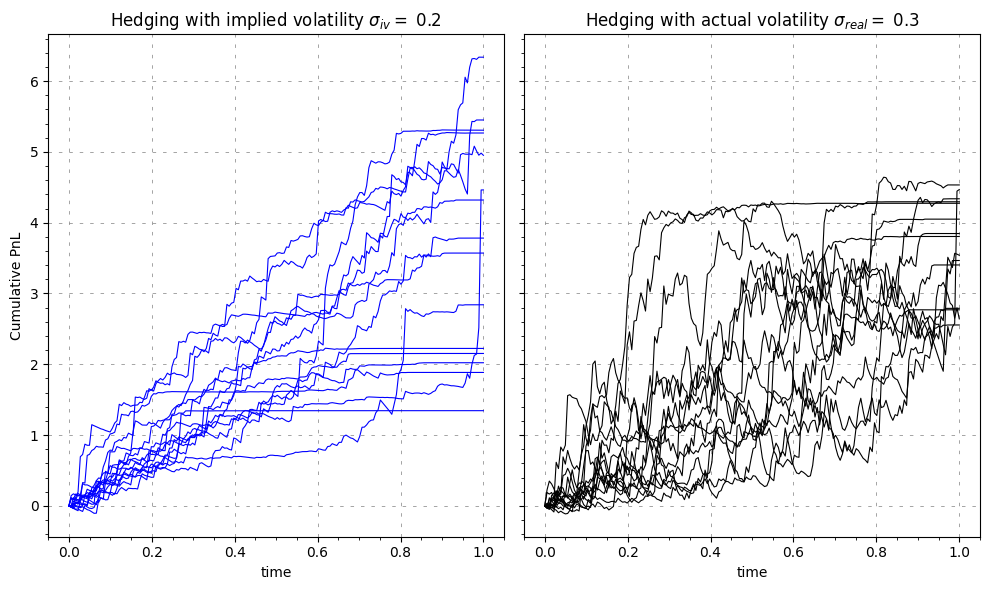

In [8]:
number_plots = 15  # must be < nPaths

# Plotting results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

time_points = np.linspace(0, 1, nbr_hedges + 1)

# Hedging with actual volatility
ax1.set_title(
    "Hedging with implied volatility " + r"$\sigma_{iv} =$ " + str(implied_volatility)
)
for i in range(number_plots):
    ax1.plot(
        time_points, portfolio_iv[i, :], color="blue", linewidth=0.8
    )  # Add transparency for better readability
ax1.grid(linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5)
ax1.minorticks_on()
ax1.set_xlabel("time")
ax1.set_ylabel("Cumulative PnL")

# Hedging with implied volatility
ax2.set_title(
    "Hedging with actual volatility " + r"$\sigma_{real} =$ " + str(real_volatility)
)
for i in range(number_plots):
    ax2.plot(
        time_points, portfolio_real[i, :], color="black", linewidth=0.8
    )  # Add transparency for better readability
ax2.grid(linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5)
ax2.minorticks_on()
ax2.set_xlabel("time")

plt.tight_layout()
plt.show()

Plot the distribution of the portfolio returns

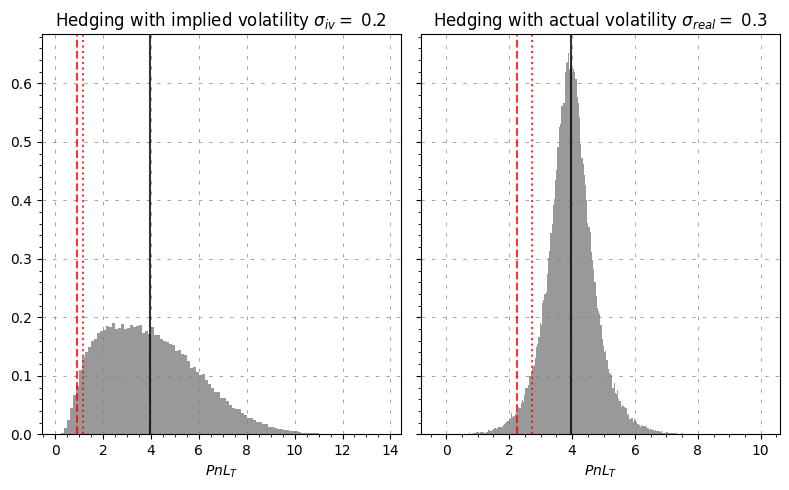

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5), sharey=True)


ax1.set_title(
    "Hedging with implied volatility " + r"$\sigma_{iv} =$ " + str(implied_volatility)
)

final_pnl_iv = portfolio_iv[:, -1]
final_pnl_iv = np.sort(final_pnl_iv)
VaR95_index = int(0.05 * len(final_pnl_iv))
VaR95 = final_pnl_iv[VaR95_index]
CVaR95 = np.mean(final_pnl_iv[:VaR95_index])

ax1.axvline(np.mean(final_pnl_iv), color="black", label="mean", alpha=0.8)
ax1.axvline(VaR95, color='red', label=r'$VaR_{95\%}$', linestyle="dotted",alpha=0.8)
ax1.axvline(CVaR95, color='red', label=r'$CVaR_{95\%}$', linestyle="--", alpha=0.8)

ax1.hist(final_pnl_iv, bins="fd", density=True, color="gray", alpha=0.8)
ax1.grid(linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5)
ax1.minorticks_on()
ax1.set_xlabel("$PnL_T$")



ax2.set_title(
    "Hedging with actual volatility " + r"$\sigma_{real} =$ " + str(real_volatility)
)

final_pnl_actual = portfolio_real[:, -1]
final_pnl_actual = np.sort(final_pnl_actual)
VaR95_index = int(0.05 * len(final_pnl_actual))
VaR95 = final_pnl_actual[VaR95_index]
CVaR95 = np.mean(final_pnl_actual[:VaR95_index])

ax2.axvline(np.mean(final_pnl_actual), color="black", label="mean", alpha=0.8)
ax2.axvline(VaR95, color='red', label=r'$VaR_{95\%}$', linestyle="dotted",alpha=0.8)
ax2.axvline(CVaR95, color='red', label=r'$CVaR_{95\%}$', linestyle="--", alpha=0.8)

ax2.hist(final_pnl_actual, bins="fd", density=True, color="gray", alpha=0.8)
ax2.grid(linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5)
ax2.minorticks_on()
ax2.set_xlabel("$PnL_T$")

plt.tight_layout()
plt.show()

Some statistics about the two portfolio

In [10]:
# Statistics

# Hedging with implied volatility
final_pnl = portfolio_iv[:, -1]
mean_pnl = np.mean(final_pnl)
std_pnl = np.std(final_pnl)
pathwise_var = np.mean([np.sum(np.diff(portfolio_iv[i]) ** 2) for i in range(nbr_simulations)])

print(f"Experiment 1 (blue) - Hedging with implied volatility:")
print(f"  Mean PnL(T): {mean_pnl:.2f}")
print(f"  Std Dev PnL(T): {std_pnl:.2f}")
print(f"  Pathwise Quadratic Variation: {pathwise_var:.2f}\n")

# Hedging with actual/forecasted volatility
final_pnl = portfolio_real[:, -1]
mean_pnl = np.mean(final_pnl)
std_pnl = np.std(final_pnl)
pathwise_var = np.mean([np.sum(np.diff(portfolio_real[i]) ** 2) for i in range(nbr_simulations)])

print(f"Experiment 2 (black) - Hedging with actual/forecasted volatility:")
print(f"  Mean PnL(T): {mean_pnl:.2f}")
print(f"  Std Dev PnL(T): {std_pnl:.2f}")
print(f"  Pathwise Quadratic Variation: {pathwise_var:.2f}\n")

Experiment 1 (blue) - Hedging with implied volatility:
  Mean PnL(T): 3.96
  Std Dev PnL(T): 1.99
  Pathwise Quadratic Variation: 1.13

Experiment 2 (black) - Hedging with actual/forecasted volatility:
  Mean PnL(T): 3.96
  Std Dev PnL(T): 0.78
  Pathwise Quadratic Variation: 4.23

